# Chapter 4: Bayesian Statistics in pymc3 (Working in progress proof of concept)

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../")

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np

In [2]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([696000-10000,747000 + 20600,6863000 - 20600,6950000 + 20600,-20000, 600],[50, 50, 50],
                         path_f = os.pardir+"/input_data/a_Foliations.csv",
                         path_i = os.pardir+"/input_data/a_Points.csv")

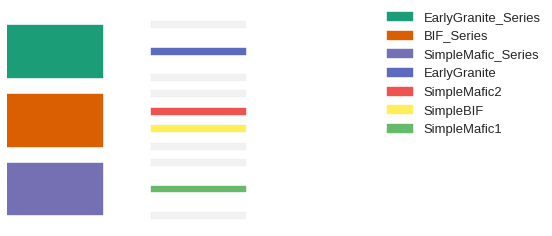

In [3]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"EarlyGranite_Series": 'EarlyGranite', 
                              "BIF_Series":('SimpleMafic2', 'SimpleBIF'),
                              "SimpleMafic_Series":'SimpleMafic1'}, 
                      order_series = ["EarlyGranite_Series",
                                      "BIF_Series",
                                      "SimpleMafic_Series"],
                      order_formations= ['EarlyGranite', 'SimpleMafic2', 'SimpleBIF', 'SimpleMafic1'],
              verbose=1)

Setting uncertainties adding the values to the Dataframe.

In [4]:
geo_data.interfaces['X_std'] = None
geo_data.interfaces['Y_std'] = 0
geo_data.interfaces['Z_std'] = 800

geo_data.foliations['X_std'] = None
geo_data.foliations['Y_std'] = 0
geo_data.foliations['Z_std'] = 0

geo_data.foliations['dip_std'] = 10
geo_data.foliations['azimuth_std'] = 10
geo_data.foliations.head()

,X,Y,Z,azimuth,dip,polarity,formation,series,order_series,isFault,formation number,annotations,G_x,G_y,G_z,X_std,Y_std,Z_std,dip_std,azimuth_std
0,722403.8130,6880913.25,470.707065,123.702047,80.0,1,EarlyGranite,EarlyGranite_Series,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},0}$",0.819295,-0.546444,0.173648,None,0,0,10,10
1,718928.3440,6883605.50,509.462245,176.274084,80.0,1,EarlyGranite,EarlyGranite_Series,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},1}$",0.063996,-0.982726,0.173648,None,0,0,10,10
2,720690.5630,6882822.25,489.909423,254.444427,80.0,1,EarlyGranite,EarlyGranite_Series,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},2}$",-0.948735,-0.264099,0.173648,None,0,0,10,10
3,721229.0005,6880766.25,477.680894,255.876557,80.0,1,EarlyGranite,EarlyGranite_Series,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},3}$",-0.955039,-0.240305,0.173648,None,0,0,10,10
4,710459.8440,6880521.50,511.839758,232.658556,80.0,1,EarlyGranite,EarlyGranite_Series,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},4}$",-0.782957,-0.597349,0.173648,None,0,0,10,10


In [5]:
# input_data_T = interp_data.interpolator.tg.input_parameters_list()
# input_data_P = interp_data.get_input_data(u_grade=[3, 3])
# select = interp_data.interpolator.pandas_rest_layer_points['formation'] == 'Reservoir'

In [6]:
interp_data_grav = gp.InterpolatorInput(geo_data, output='gravity', compile_theano=False,
                                   u_grade=[3, 3, 3])

In [7]:
gp.set_geophysics_obj(interp_data_grav,  [7.050000e+05,747000,6863000,6925000,-20000, 200],
                                             [50,50], )

In [8]:
gp.precomputations_gravity(interp_data_grav, 25, [2.92, 3.1, 2.92, 2.61, 2.61])

(array([[  2.32206772e-05,   1.38317570e-05,   4.37779836e-06, ...,
           1.38316011e-05,   4.37774898e-06,  -5.09674338e-06],
        [  2.32206772e-05,   1.38317570e-05,   4.37779837e-06, ...,
           1.38316011e-05,   4.37774898e-06,  -5.09674338e-06],
        [  2.32206772e-05,   1.38317570e-05,   4.37779837e-06, ...,
           1.38316011e-05,   4.37774898e-06,  -5.09674338e-06],
        ..., 
        [  2.32204160e-05,   1.38316011e-05,   4.37774898e-06, ...,
           1.38316011e-05,   4.37774898e-06,  -5.09674338e-06],
        [  2.32204160e-05,   1.38316011e-05,   4.37774898e-06, ...,
           1.38316011e-05,   4.37774898e-06,  -5.09674338e-06],
        [  2.32204160e-05,   1.38316011e-05,   4.37774898e-06, ...,
           1.38316011e-05,   4.37774898e-06,  -5.09674338e-06]]),
 array([False, False, False, ..., False, False, False], dtype=bool))

Now the generation of the geomodel will be an operation embedded in a larger tree.

In [7]:
import theano
import theano.tensor as T
geomodel = theano.OpFromGraph(interp_data_grav.interpolator.tg.input_parameters_list(),
                              interp_data_grav.interpolator.tg.compute_geological_model(n_faults=0, compute_all=True),
                              on_unused_input='ignore',
                            )

In [9]:
import theano
import theano.tensor as T
geomodel = theano.OpFromGraph(interp_data_grav.interpolator.tg.input_parameters_list(),
                              [interp_data_grav.interpolator.tg.compute_forward_gravity(n_faults=0, compute_all=True)],
                              on_unused_input='ignore',
                            )

Because now the GeMpy model is a theano operation and not a theano function, to call it we need to use theano variables (with theano functions we call them with python variables). This is very easy to modify, we just need to use theano shared to convert our python input data into theano variables.

The pymc3 objects are already theano variables (pm.Normal and so on). Now the trick is that using the theano function T.set_subtensor, we can change one deterministic value of the input arrays(the ones printed in the cell above) by a stochastic pymc3 object. Then with the new arrays we just have to call the theano operation and pymc will do the rest

In [10]:
# This is the creation of the model
import pymc3 as pm
theano.config.compute_test_value = 'off'
#theano.config.warn_float64 = 'warn'
model = pm.Model()
with model:
    # We create the Stochastic parameters. In this case only the Z position
    # of the interfaces
    Z_rest = pm.Normal('Z_unc_rest',
       interp_data_grav.interpolator.pandas_rest_layer_points['Z'].as_matrix().astype('float32'),
       interp_data_grav.interpolator.pandas_rest_layer_points['Z_std'].as_matrix().astype('float32'),
                  dtype='float32', shape = (66))
    
    Z_ref = pm.Normal('Z_unc_ref', interp_data_grav.interpolator.pandas_ref_layer_points_rep['Z'].astype('float32'),
              interp_data_grav.interpolator.pandas_ref_layer_points_rep['Z_std'].astype('float32'),
              dtype='float32', shape = (66))
    
#     Z_unc = pm.Normal('Z_unc', interp_data_grav.geo_data_res.interfaces['Z'].astype('float32'),
#                       interp_data_grav.geo_data_res.interfaces['Z_std'].astype('float32'), dtype='float32', shape= (70))
    
#     interp_data_grav.geo_data_res.interfaces['Z'] = Z_unc
    
    # We convert a python variable to theano.shared
    input_sh = []
    for i in interp_data_grav.get_input_data():
        input_sh.append(theano.shared(i))
    
    # We add the stochastic value to the correspondant array. rest array is
    # a n_points*3 (XYZ) array. We only want to change Z in this case.
    input_sh[4] = T.set_subtensor(
    input_sh[4][:, 2], Z_ref)

    input_sh[5] = T.set_subtensor(
    input_sh[5][:, 2], Z_rest)
    
    # With the stochastic parameters we create the geomodel result:
    geo_model = pm.Deterministic('GemPy', geomodel(input_sh[0], input_sh[1], input_sh[2],
                                                   input_sh[3], input_sh[4], input_sh[5]))

In [11]:
theano.config.compute_test_value = 'ignore'
# This is the sampling
# BEFORE RUN THIS FOR LONG CHECK IN THE MODULE THEANOGRAF THAT THE FLAG 
# THEANO OPTIMIZER IS IN 'fast_run'!!
with model:
   # backend = pm.backends.ndarray.NDArray('geomodels')
    step = pm.NUTS()
    trace = pm.sample(30, tune=10, init=None, step=step, )

100%|██████████| 40/40 [01:36<00:00,  2.25s/it]/home/miguel/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:418: UserWarning: Chain 0 contains only 30 samples.
  % (self._chain_id, n))
/home/miguel/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.955144655704, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



In [13]:
trace.get_values('GemPy')[5] -  trace.get_values('GemPy')[15]

array([-0.00171852, -0.00116444, -0.00116444, ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

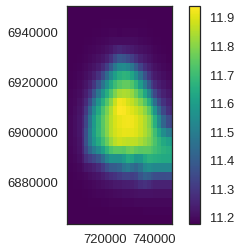

In [18]:
import matplotlib.pyplot as plt
plt.imshow(trace.get_values('GemPy')[-10].reshape(50,50), cmap='viridis', origin='lower', extent=[7.050000e+05,747000,6863000,6950000] )
plt.colorbar()

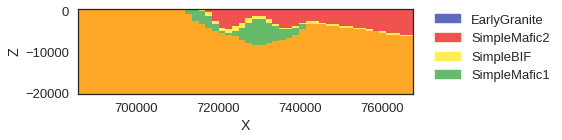

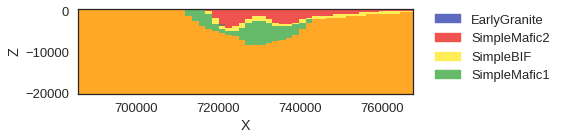

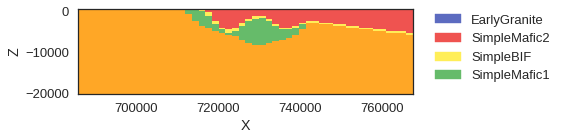

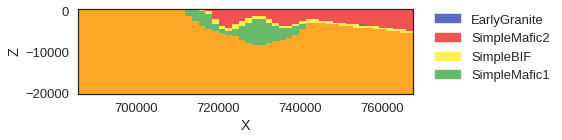

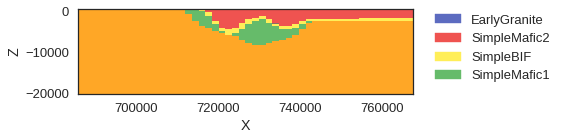

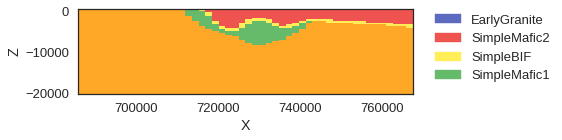

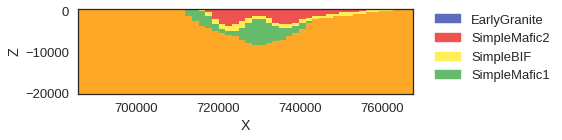

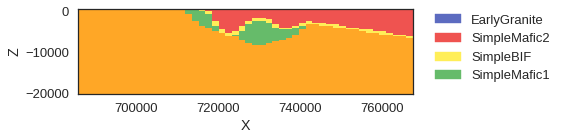

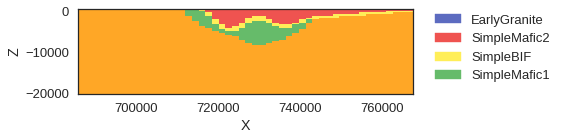

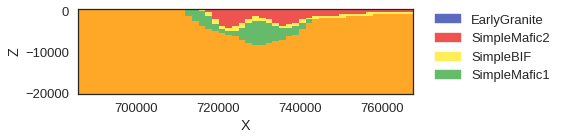

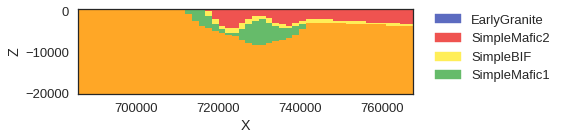

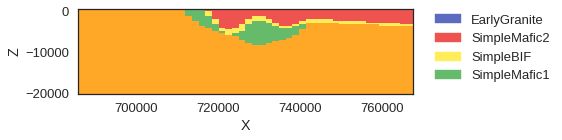

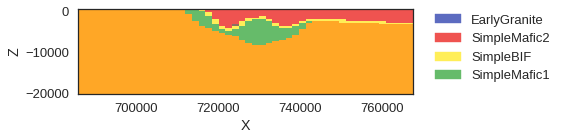

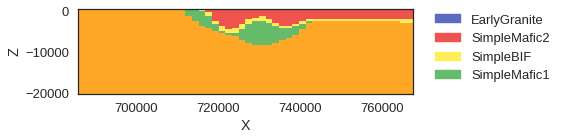

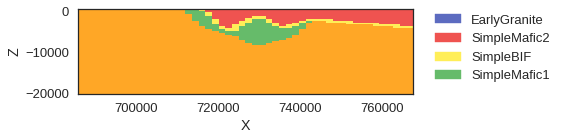

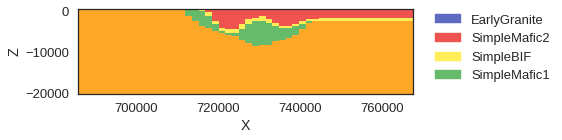

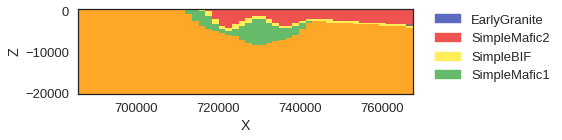

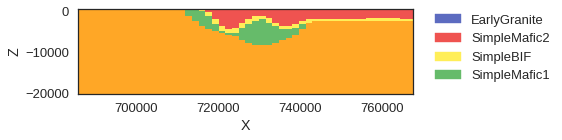

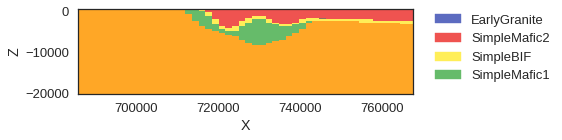

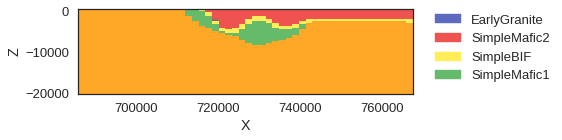

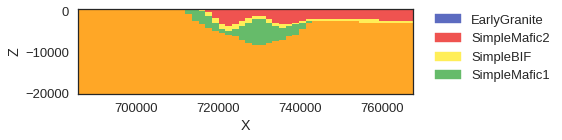

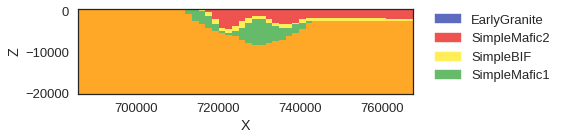

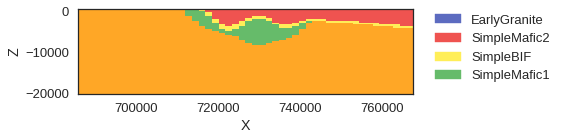

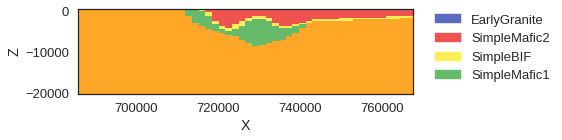

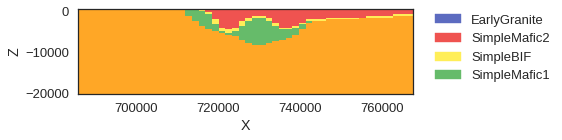

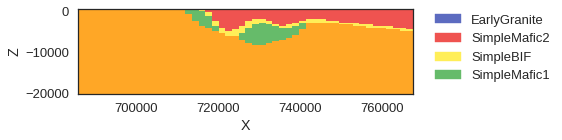

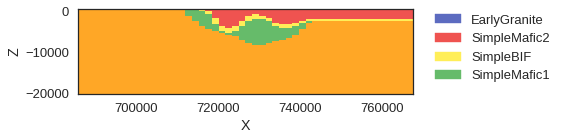

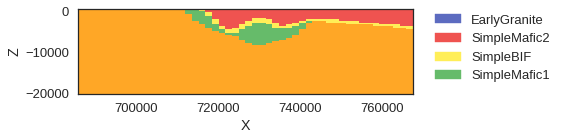

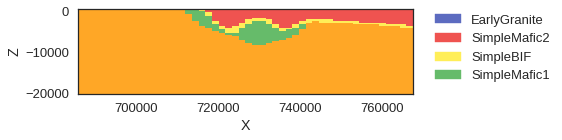

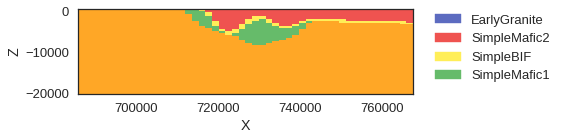

IndexError: index 30 is out of bounds for axis 0 with size 30

In [13]:
import matplotlib.pyplot as plt
for i in range(100):
    gp.plot_section(geo_data, trace.get_values('GemPy')[i][0, :], 18,
                       direction='y', plot_data=False)
    plt.show()

In [19]:
from theano.printing import pydotprint

pydotprint(model.logpt)

The output file is available at /home/miguel/.theano/compiledir_Linux-4.10--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.1-64/theano.pydotprint.cpu.png
